<a href="https://colab.research.google.com/github/dchatrina/PA-PDAB-A24/blob/main/Algoritma_Supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

In [2]:
df = pd.read_csv("https://drive.google.com/uc?id=1N85vFcEgviXKdd2fPJuT6ieBWF1DNIzv")

#Data Preparation

###Cleaning Data

In [3]:
df.isna().sum()

long_hair                    0
forehead_width_cm            0
forehead_height_cm           0
nose_wide                    0
nose_long                    0
lips_thin                    0
distance_nose_to_lip_long    0
gender                       0
dtype: int64

In [4]:
results = []

cols = df.select_dtypes(include=['float64', 'int64'])

for col in cols:
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75) 
  iqr = q3 - q1
  lower_bound = q1 - 1.5*iqr
  upper_bound = q3 + 1.5*iqr
  outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
  percent_outliers = (len(outliers)/len(df))*100
  results.append({'Kolom': col, 'Persentase Outliers': percent_outliers})

# Dataframe dari list hasil
results_df = pd.DataFrame(results)
results_df.set_index('Kolom', inplace=True)
results_df = results_df.rename_axis(None, axis=0).rename_axis('Kolom', axis=1)

# Tampilkan dataframe
display(results_df)


Kolom,Persentase Outliers
long_hair,13.037393
forehead_width_cm,0.000000
forehead_height_cm,0.000000
nose_wide,0.000000
nose_long,0.000000
lips_thin,0.000000
distance_nose_to_lip_long,0.000000


Outliers ga dihapus karena di atas 10%

###Transform Data

In [5]:
df['gender'] = df['gender'].map({'Male':1,'Female':0})

###Slicing Data

In [6]:
df_sliced = df.sample(n=1000, random_state=42)

###Format Data

#####Encoding

In [7]:
df_final = pd.get_dummies(df_sliced)

#####Splitting

In [8]:
x = df_final.drop('gender',axis=1)
y = df_final['gender']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

#####Cross Validation

In [9]:
# definisikan model KNN
clf = KNeighborsClassifier()

# definisikan hyperparameter yang ingin diuji
param_grid = {'n_neighbors': [3, 5, 7, 9,11,13,15,17,19]}

# inisialisasi GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=2)

# latih model dengan GridSearchCV
grid_search.fit(x_train, y_train)

# tampilkan parameter terbaik
print("Nilai k terbaik:", grid_search.best_params_['n_neighbors'])

# tampilkan skor validasi terbaik
print("Skor validasinya:", grid_search.best_score_)


Nilai k terbaik: 19
Skor validasinya: 0.9642857142857142


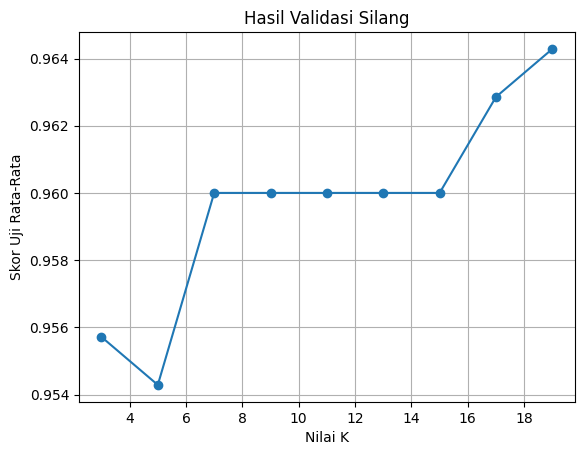

In [10]:
# ambil nilai skor validasi dari grid search
mean_scores = grid_search.cv_results_['mean_test_score']
std_scores = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

# plot hasil dari grid search
plt.errorbar(
    [params[i]['n_neighbors'] for i in range(len(params))],
    mean_scores,
    # yerr=std_scores,
    fmt='o-'
)
plt.xlabel('Nilai K')
plt.ylabel('Skor Uji Rata-Rata')
plt.title('Hasil Validasi Silang')
plt.grid(True)
plt.show()


#Modelling

###Pre-Processing

###Implementation

#####Naive Bayes

In [11]:
class GaussianNB:
    # Constructor
    def __init__(self):
        self.sigmas = dict()
        self.dispersions = dict()
        self.probs = dict()
        self.targets = list()
        self.columns = list()
    
    # Fit method
    def fit(self, x, y):
        self.__init__()
        
        # Preparing DataFrame
        dataset = pd.DataFrame(data=x, index=None)
        dataset[y.name] = y
        
        # Preparing sigma / dispersion dictionaries 
        for column in dataset.drop(y.name, axis=1):
            self.sigmas[column] = dict()
            self.dispersions[column] = dict()
            for target in dataset[y.name].unique():
                sample = np.array(dataset.query('{0} == @target'.format(y.name))[column])
                self.sigmas[column][target] = sample.std()
                self.dispersions[column][target] = sample.mean()
                self.probs[column] = len(sample) / len(x)
        
        self.targets = dataset[y.name].unique()
        self.columns = x.columns
    
    # Predict method
    def predict(self, X):
        predicts = list()
        for row in X.to_numpy():
            target_prob_dict = dict()
            for target in self.targets:
                for x, column in zip(row, self.columns[:-1]):
                    x = float(x)
                    sigma = self.sigmas[column][target]
                    dispersion = self.dispersions[column][target]
                    prob = self.probs[column]
                    target_prob = ((1 / np.sqrt(np.pi*sigma)) * np.exp(-( (x-dispersion)**2 / (2*sigma**2)))) * prob
                    target_prob_dict[target] = target_prob_dict.get(target, 1) * target_prob
            predicts.append(max(target_prob_dict, key=target_prob_dict.get))
        return predicts

In [12]:
# definisikan model Naive Bayes
gnb = GaussianNB()

# latih model Naive Bayes
gnb.fit(x_train, y_train)

# evaluasi performa model menggunakan data uji
gnb_pred = gnb.predict(x_test)

#####KNN

In [13]:
class KNeighbors:
    def __init__(self, n_neighbors=None):
        self.n_neighbors = n_neighbors
        
    def fit(self, X, y):
        self.X_train = np.array(X.drop('gender', axis=1))
        self.y_train = np.array(y)
        
    def predict(self, X_test):
        X_test = np.array(X_test)
        y_pred = np.zeros(X_test.shape[0], dtype=self.y_train.dtype)
        for i, x_test in enumerate(X_test):
            distances = np.sqrt(np.sum((self.X_train - x_test)**2, axis=1))
            indices = np.argsort(distances)[:self.n_neighbors]
            k_nearest_classes = self.y_train[indices]
            y_pred[i] = np.argmax(np.bincount(k_nearest_classes))
        return y_pred

In [14]:
# Inisialisasi model KNN dengan k=5
knn = KNeighbors(n_neighbors=7)

# Train model menggunakan data train
knn.fit(x_train, y_train)

# Prediksi label pada data test
knn_pred = knn.predict(x_test)

#####C4.5

In [15]:
# inisialisasi model Decision Tree Classifier
dtc = DecisionTreeClassifier()

# train model pada data train
dtc.fit(x_train.drop('gender',axis=1), y_train)

# evaluasi model pada data test
dtc_pred = dtc.predict(x_test)

#Evaluation

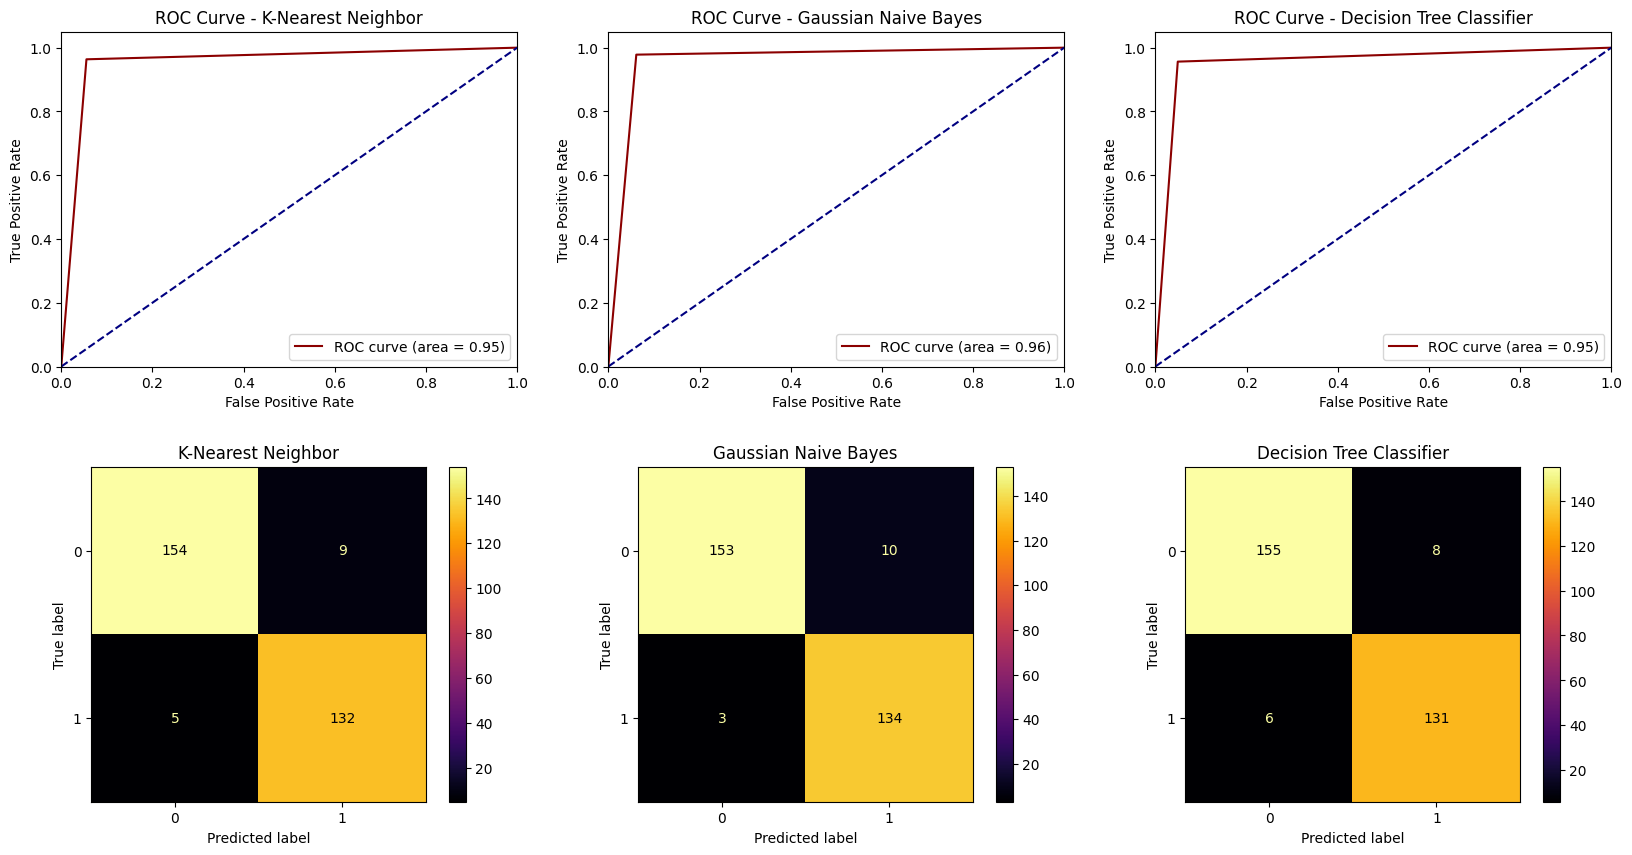

,Accuracy (%),Precision (%),Recall (%),ROC-AUC (%),F1-Score (%)
K-Nearest Neighbor,95.333333,93.617021,96.350365,95.414446,94.964029
Gaussian Naive Bayes,95.666667,93.055556,97.810219,95.837625,95.373665
Decision Tree Classifier,95.333333,94.244604,95.620438,95.356231,94.927536


In [16]:
# buat list model dan nama model
models = [knn, gnb, dtc]
model_names = ['K-Nearest Neighbor', 'Gaussian Naive Bayes', 'Decision Tree Classifier']

# inisialisasi list untuk menyimpan hasil evaluasi
acc_scores = []
pre_scores = []
rec_scores = []
roc_scores = []
f1_scores = []

# buat figure dan axes untuk menampilkan visualisasi
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

# loop untuk setiap model
for i, model in enumerate(models):
    # prediksi target variabel pada data uji
    y_pred = model.predict(x_test)

    # hitung confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # hitung nilai roc-auc
    roc = roc_auc_score(y_test, y_pred)

    # hitung false positive rate (fpr) dan true positive rate (tpr) untuk kurva roc
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    # tampilkan kurva roc
    roc_display = axes[0,i].plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.2f)' % roc)
    roc_display = axes[0,i].plot([0, 1], [0, 1], color='navy', linestyle='--')
    roc_display = axes[0,i].set_xlim([0.0, 1.0])
    roc_display = axes[0,i].set_ylim([0.0, 1.05])
    roc_display = axes[0,i].set_xlabel('False Positive Rate')
    roc_display = axes[0,i].set_ylabel('True Positive Rate')
    roc_display = axes[0,i].set_title('ROC Curve - ' + model_names[i])
    roc_display = axes[0,i].legend(loc="lower right")

    # tambahkan baris kosong
    fig.subplots_adjust(hspace=0.3)

    # tampilkan confusion matrix
    cm_display = ConfusionMatrixDisplay(cm).plot(ax=axes[1,i], cmap='inferno')
    cm_display.ax_.set_title(model_names[i])

    # hitung true negative, false positive, false negative, true positive
    tn, fp, fn, tp = cm.ravel()

    # hitung akurasi, precision, recall, dan f1-score
    ac = (tp + tn) / (tp + fp + fn + tn)
    pr = tp / (tp + fp)
    rc = tp / (tp + fn)
    f1 = (2 * pr * rc) / (pr+rc)

    # simpan hasil evaluasi pada list
    acc_scores.append(ac * 100)
    pre_scores.append(pr * 100)
    rec_scores.append(rc * 100)
    roc_scores.append(roc * 100)
    f1_scores.append(f1 * 100)

# tampilkan visualisasi
plt.show()

# buat dataframe dari hasil evaluasi
df_eval = pd.DataFrame({'': model_names,
                        'Accuracy (%)': acc_scores,
                        'Precision (%)': pre_scores,
                        'Recall (%)': rec_scores,
                        'ROC-AUC (%)': roc_scores,
                        'F1-Score (%)': f1_scores})

# set index dataframe menjadi kosong
df_eval = df_eval.set_index('')

# ubah nama axis pada index dan kolom
df_eval = df_eval.rename_axis(None, axis=0).rename_axis('', axis=1)

# menampilkan dataframe dengan style untuk highlight nilai tertinggi
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

df_eval = df_eval.style.apply(highlight_max, axis=0)

# tampilkan dataframe
display(df_eval)